In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install kneed

In [ ]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from collections import defaultdict
from functools import reduce
import os
import joblib
import pickle
import glob
import json

from joblib import Parallel, delayed, dump, load
from multiprocessing import Manager, Lock
from scipy.stats import multivariate_normal
import optuna
from optuna.samplers import TPESampler
from typing import Tuple

import matplotlib.pyplot as plt
from kneed import KneeLocator

In [ ]:
#Input Parameters
randomState= 21
splitingPresentage= 0.2 #für Init und Iter Pretraining
nTrailsPre= 50
silhouetteSampleSize= 100000
nComponents = list(range(2, 31)) #sinvolle Werte 1-20
nInit = (1, 20) #[5, 10, 15, 20] #sinvolle Werte 1-20
nIter = (50, 500) #[100, 150, 200] #sinvolle Werte 50-500
nInitFirstStep= 5
nIterFirstStep= 150
nJobs= -1
nTrials= 10
folds= 5
selected_folds = [0, 1]

storagePath= "/content/drive/MyDrive/26-2BJXXXX_model_weather_station Data/rowWiseModelFinal/"


In [ ]:
#Laden der Rowwise Daten da bessser geeignet
df = pd.read_pickle("/content/drive/MyDrive/26-2BJXXXX_model_weather_station Data/rowwiseDf.pkl")

In [ ]:
df= df.drop(columns= ['MESS_DATUM', 'STATIONS_ID', 'RS_IND', 'WRTR','   P', '   D', 'Stationsname', 'hour', 'day', 'month'])
#df= df.drop(columns= ['STATIONS_ID','RS_IND_00','RS_IND_01','RS_IND_02','RS_IND_03','RS_IND_04','RS_IND_05','RS_IND_06','RS_IND_07','RS_IND_08','RS_IND_09','RS_IND_10','RS_IND_11','RS_IND_12','RS_IND_13','RS_IND_14','RS_IND_15','RS_IND_16','RS_IND_17','RS_IND_18','RS_IND_19','RS_IND_20','RS_IND_21','RS_IND_22','RS_IND_23','WRTR_00','WRTR_01','WRTR_02','WRTR_03','WRTR_04','WRTR_05','WRTR_06','WRTR_07','WRTR_08','WRTR_09','WRTR_10','WRTR_11','WRTR_12','WRTR_13','WRTR_14', 'WRTR_15', 'WRTR_16', 'WRTR_17', 'WRTR_18', 'WRTR_19', 'WRTR_20', 'WRTR_21', 'WRTR_22', 'WRTR_23','   P_00','   P_01','   P_02','   P_03','   P_04','   P_05','   P_06','   P_07','   P_08','   P_09','   P_10','   P_11','   P_12','   P_13','   P_14','   P_15','   P_16','   P_17','   P_18','   P_19','   P_20','   P_21','   P_22','   P_23','   D_00','   D_01', '   D_02','   D_03','   D_04','   D_05','   D_06','   D_07','   D_08','   D_09','   D_10','   D_11','   D_12','   D_13','   D_14','   D_15','   D_16','   D_17','   D_18','   D_19','   D_20','   D_21','   D_22','   D_23','Stationsname', 'day', 'month'])

In [ ]:
df.columns

Index(['TT_TU', 'RF_TU', '  R1', '  P0', '   F', 'Stationshoehe', 'geoBreite',
       'geoLaenge', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

In [ ]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
X = df.values

In [ ]:
scaler= StandardScaler()
xScaled= scaler.fit_transform(X)

In [ ]:
os.makedirs(storagePath, exist_ok=True)

In [ ]:
n_splits = folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=randomState)
n_components_list = nComponents

In [ ]:
manager = Manager()
bic_scores = manager.dict({n: manager.list([None]*n_splits) for n in n_components_list})
lock = manager.Lock()

In [ ]:
results_file = storagePath + "bic_results.json"
models_dir = storagePath + "gmm_models"
os.makedirs(models_dir, exist_ok=True)

In [ ]:
# Lade existierende Ergebnisse
if os.path.exists(results_file):
    with open(results_file, "r") as f:
        loaded = json.load(f)
    bic_scores = {int(k): v for k, v in loaded.items()}
else:
    bic_scores = {n: [None] * n_splits for n in n_components_list}

In [ ]:
def fit_and_save_gmm(n_comp, fold_idx, X_train, X_val):
    model_path = f"{models_dir}/gmm_n{n_comp}_fold{fold_idx}.joblib"
    # Skip wenn Modell existiert und Ergebnis schon da
    if os.path.exists(model_path) and bic_scores[n_comp][fold_idx] is not None:
        return

    # Modell trainieren
    gmm = GaussianMixture(n_components=n_comp, n_init=nInitFirstStep, max_iter=nIterFirstStep, random_state=randomState)
    gmm.fit(X_train)
    dump(gmm, model_path)

    # BIC berechnen
    bic = gmm.bic(X_val)
    bic_scores[n_comp][fold_idx] = bic

    # JSON sofort aktualisieren
    with lock:
        with open(results_file, "w") as f:
            json.dump(
                {str(k): list(v) for k, v in bic_scores.items()},
                f,
                indent=2
            )

    print(f"Gespeichert: n={n_comp}, fold={fold_idx}, BIC={bic:.2f}")

In [ ]:
# 5-Fold CV vorbereiten
kf = KFold(n_splits=n_splits, shuffle=True, random_state=randomState)
param_list = []

In [ ]:
# Alle Splits speichern
if False:
  splits = []
  for fold_idx, (train_idx, val_idx) in enumerate(kf.split(xScaled)):
      splits.append({
          "fold": fold_idx,
          "train_idx": train_idx.tolist(),
          "val_idx": val_idx.tolist()
      })

  # In JSON-Datei sichern
  with open(storagePath + "splits.json", "w") as f:
      json.dump(splits, f, indent=2)

In [ ]:
# Folds laden
with open(storagePath + "splits.json", "r") as f:
    folds = json.load(f)

In [ ]:
jobs = []
for fold_info in folds:
    if fold_info["fold"] in selected_folds:
        train_idx = np.array(fold_info["train_idx"])
        val_idx   = np.array(fold_info["val_idx"])
        X_train, X_val = xScaled[train_idx], xScaled[val_idx]

        for n_comp in n_components_list:
            jobs.append(delayed(fit_and_save_gmm)(n_comp, fold_info["fold"], X_train, X_val))

In [ ]:
"""for fold_idx, (train_idx, val_idx) in enumerate(kf.split(xScaled)):
    X_train, X_val = xScaled[train_idx], xScaled[val_idx]
    for n_comp in n_components_list:
        param_list.append((n_comp, fold_idx, X_train, X_val))
        jobs.append(delayed(fit_and_save_gmm)(n_comp, fold_idx, X_train, X_val))"""

'for fold_idx, (train_idx, val_idx) in enumerate(kf.split(xScaled)):\n    X_train, X_val = xScaled[train_idx], xScaled[val_idx]\n    for n_comp in n_components_list:\n        param_list.append((n_comp, fold_idx, X_train, X_val))\n        jobs.append(delayed(fit_and_save_gmm)(n_comp, fold_idx, X_train, X_val))'

In [ ]:
# Parallel ausführen
Parallel(n_jobs=-1, backend="threading")(jobs)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
with open(results_file, "r") as f:
    data = json.load(f)

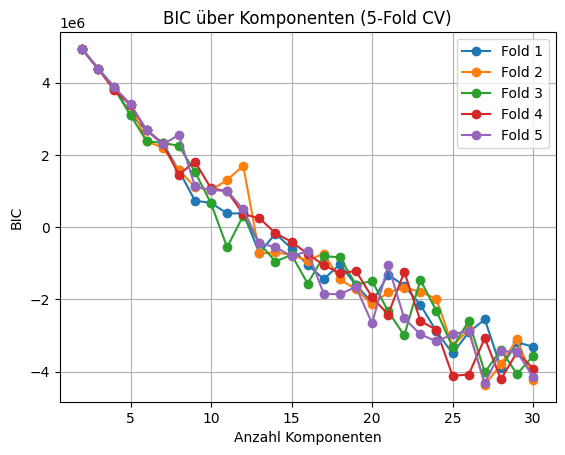

In [ ]:
# Keys sortieren (Komponenten)
components = sorted(map(int, data.keys()))

# Jede Fold-Spalte als eigene Kurve plotten
n_folds = len(next(iter(data.values())))
for fold_idx in range(n_folds):
    fold_values = [data[str(k)][fold_idx] for k in components]
    plt.plot(components, fold_values, marker="o", label=f"Fold {fold_idx+1}")

plt.xlabel("Anzahl Komponenten")
plt.ylabel("BIC")
plt.title("BIC über Komponenten (5-Fold CV)")
plt.legend()
plt.grid(True)
plt.show()

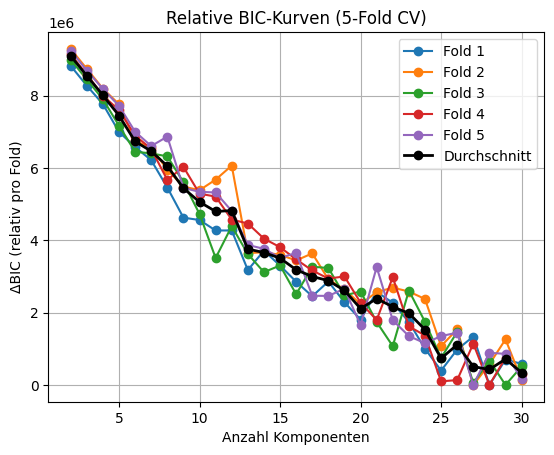

In [ ]:
components = sorted(map(int, data.keys()))
n_folds = len(next(iter(data.values())))

# Alle Werte in eine Matrix
bic_matrix = np.array([[data[str(k)][fold] for fold in range(n_folds)] for k in components])

# BIC relativ zum Minimum je Fold darstellen
bic_rel = bic_matrix - bic_matrix.min(axis=0)

for fold_idx in range(n_folds):
    plt.plot(components, bic_rel[:, fold_idx], marker="o", label=f"Fold {fold_idx+1}")

# Zusätzlich Durchschnittskurve
mean_curve = bic_rel.mean(axis=1)
plt.plot(components, mean_curve, marker="o", color="black", linewidth=2, label="Durchschnitt")

plt.xlabel("Anzahl Komponenten")
plt.ylabel("ΔBIC (relativ pro Fold)")
plt.title("Relative BIC-Kurven (5-Fold CV)")
plt.legend()
plt.grid(True)
plt.show()

Elbow bei: 10


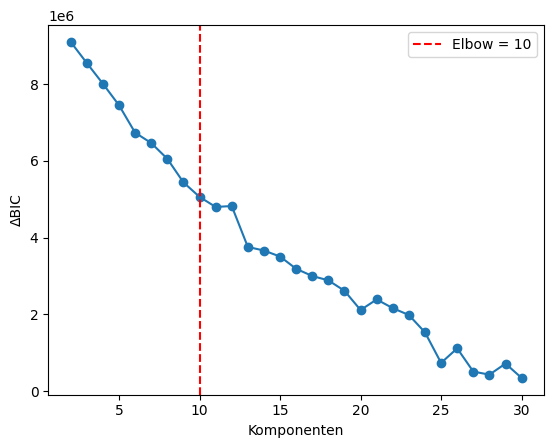

In [ ]:
kl = KneeLocator(components, mean_curve, curve="convex", direction="decreasing")
print("Elbow bei:", kl.knee)

plt.plot(components, mean_curve, marker="o")
plt.axvline(kl.knee, color="red", linestyle="--", label=f"Elbow = {kl.knee}")
plt.xlabel("Komponenten")
plt.ylabel("ΔBIC")
plt.legend()
plt.show()

In [ ]:
1/0

ZeroDivisionError: division by zero

In [ ]:
nComponents= 10

In [ ]:
_, X_subset = train_test_split(xScaled, test_size= 0.2, random_state=randomState)
print(X_subset.shape)

(333063, 14)


In [ ]:
def objective(trial):
    n_init = trial.suggest_int("n_init", 1, 25)         # grober Bereich
    max_iter = trial.suggest_int("max_iter", 50, 500)   # grober Bereich

    # feste Anzahl Komponenten nehmen (z.B. deine "beste" aus BIC, sagen wir 16)
    gmm = GaussianMixture(
        n_components=16,
        n_init=n_init,

        max_iter=max_iter,
        random_state=42
    )
    gmm.fit(X_subset)

    # wir optimieren hier den BIC
    return gmm.bic(X_subset)   # Minus, weil Optuna minimiert standardmäßig

In [ ]:
study = optuna.create_study(direction="minimize")  # minimieren, weil -BIC
study.optimize(objective, n_trials=30, n_jobs=-1)  # 30 Runs reichen für grob

print("Beste Parameter:", study.best_params)
print("Bester Score:", study.best_value)

[I 2025-08-19 07:21:38,866] A new study created in memory with name: no-name-ab1c0442-3638-4160-8a8f-6ac34ad96e79
[I 2025-08-19 07:43:57,511] Trial 0 finished with value: -701331.0912750155 and parameters: {'n_init': 5, 'max_iter': 253}. Best is trial 0 with value: -701331.0912750155.
[I 2025-08-19 08:14:02,541] Trial 1 finished with value: -701331.0912750155 and parameters: {'n_init': 12, 'max_iter': 294}. Best is trial 0 with value: -701331.0912750155.
[I 2025-08-19 09:09:08,643] Trial 2 finished with value: -1592455.9026271391 and parameters: {'n_init': 20, 'max_iter': 302}. Best is trial 2 with value: -1592455.9026271391.
[I 2025-08-19 09:15:19,012] Trial 0 finished with value: -1592455.9026271391 and parameters: {'n_init': 28, 'max_iter': 256}. Best is trial 0 with value: -1592455.9026271391.
[I 2025-08-19 09:20:44,999] Trial 1 finished with value: -1592455.9026271391 and parameters: {'n_init': 30, 'max_iter': 414}. Best is trial 0 with value: -1592455.9026271391.
[I 2025-08-19 09

Beste Parameter: {'n_init': 20, 'max_iter': 302}
Bester Score: -1592455.9026271391


[I 2025-08-19 07:21:38,866] A new study created in memory with name: no-name-ab1c0442-3638-4160-8a8f-6ac34ad96e79

[I 2025-08-19 07:43:57,511] Trial 0 finished with value: -701331.0912750155 and parameters: {'n_init': 5, 'max_iter': 253}. Best is trial 0 with value: -701331.0912750155.

[I 2025-08-19 08:14:02,541] Trial 1 finished with value: -701331.0912750155 and parameters: {'n_init': 12, 'max_iter': 294}. Best is trial 0 with value: -701331.0912750155.

[I 2025-08-19 09:09:08,643] Trial 2 finished with value: -1592455.9026271391 and parameters: {'n_init': 20, 'max_iter': 302}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 09:15:19,012] Trial 0 finished with value: -1592455.9026271391 and parameters: {'n_init': 28, 'max_iter': 256}. Best is trial 0 with value: -1592455.9026271391.

[I 2025-08-19 09:20:44,999] Trial 1 finished with value: -1592455.9026271391 and parameters: {'n_init': 30, 'max_iter': 414}. Best is trial 0 with value: -1592455.9026271391.

[I 2025-08-19 09:39:12,583] Trial 3 finished with value: -1592455.9026271391 and parameters: {'n_init': 25, 'max_iter': 354}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 09:54:04,708] Trial 4 finished with value: -1592455.9026271391 and parameters: {'n_init': 19, 'max_iter': 436}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 10:03:13,444] Trial 5 finished with value: -701331.0912750155 and parameters: {'n_init': 11, 'max_iter': 130}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 10:16:06,548] Trial 6 finished with value: -701331.0912750155 and parameters: {'n_init': 10, 'max_iter': 70}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 10:21:48,975] Trial 8 finished with value: -701331.0912750155 and
parameters: {'n_init': 3, 'max_iter': 416}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 10:37:57,485] Trial 7 finished with value: -1156462.090621225 and parameters: {'n_init': 16, 'max_iter': 75}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 10:38:55,216] Trial 9 finished with value: -701331.0912750155 and parameters: {'n_init': 8, 'max_iter': 222}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 10:46:59,415] Trial 10 finished with value: -701331.0912750155 and parameters: {'n_init': 4, 'max_iter': 394}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 11:26:44,309] Trial 11 finished with value: -1592455.9026271391 and parameters: {'n_init': 23, 'max_iter': 489}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 11:39:13,467] Trial 12 finished with value: -1592455.9026271391 and parameters: {'n_init': 25, 'max_iter': 353}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 12:19:04,838] Trial 13 finished with value: -1592455.9026271391 and parameters: {'n_init': 25, 'max_iter': 330}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 12:21:15,158] Trial 14 finished with value: -1592455.9026271391 and parameters: {'n_init': 20, 'max_iter': 317}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 12:56:04,184] Trial 16 finished with value: -1156462.090621225 and parameters: {'n_init': 16, 'max_iter': 249}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 13:00:52,908] Trial 15 finished with value: -1592455.9026271391 and parameters: {'n_init': 20, 'max_iter': 196}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 13:39:43,183] Trial 17 finished with value: -1592455.9026271391 and parameters: {'n_init': 21, 'max_iter': 183}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 13:46:56,427] Trial 18 finished with value: -1592455.9026271391 and parameters: {'n_init': 22, 'max_iter': 171}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 14:14:39,990] Trial 19 finished with value: -1156462.090621225 and parameters: {'n_init': 16, 'max_iter': 372}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 14:21:59,212] Trial 20 finished with value: -1156462.090621225 and parameters: {'n_init': 16, 'max_iter': 357}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 14:53:05,458] Trial 21 finished with value: -1592455.9026271391 and parameters: {'n_init': 18, 'max_iter': 479}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 15:02:02,132] Trial 22 finished with value: -1592455.9026271391 and parameters: {'n_init': 19, 'max_iter': 471}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 15:41:00,480] Trial 23 finished with value: -1592455.9026271391 and parameters: {'n_init': 23, 'max_iter': 431}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 15:49:53,602] Trial 24 finished with value: -1592455.9026271391 and parameters: {'n_init': 23, 'max_iter': 422}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 16:20:52,065] Trial 26 finished with value: -1156462.090621225 and parameters: {'n_init': 14, 'max_iter': 297}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 16:33:09,689] Trial 25 finished with value: -1592455.9026271391 and parameters: {'n_init': 25, 'max_iter': 439}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 16:59:10,828] Trial 27 finished with value: -1592455.9026271391 and parameters: {'n_init': 18, 'max_iter': 454}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 17:11:41,763] Trial 28 finished with value: -1592455.9026271391 and parameters: {'n_init': 18, 'max_iter': 383}. Best is trial 2 with value: -1592455.9026271391.

[I 2025-08-19 17:23:44,272] Trial 29 finished with value: -1156462.090621225 and parameters: {'n_init': 14, 'max_iter': 376}. Best is trial 2 with value: -1592455.9026271391.

Beste Parameter: {'n_init': 20, 'max_iter': 302}
Bester Score: -1592455.9026271391

In [ ]:
optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_slice(study)